# Question 1

In this question we will
- Implement the vector grandient operators for colour images.
- Implement the kurtosis measure of image blur/sharpness which is caluclated from image gradients and assess whether it is a reasonable metric of blur.
- Learn to create blur maps of images to visualize the amount of blur in local image patches.



# Step 1: Implement the vector gradient.

Implement the vector gradient as described in the lecture slides in the `color_sobel_edges()` function below.  Use Sobel filters to estimate partial derivatives.  Use the `color_dot_product()` function (provided) to compute the necessary dot products to obtain gxx, gyy, and gxy.  Return an array containing the gradient magnitudes for each pixel, i.e. a graident magnitude image.  Optionally, return a second array containing the gradient directions for each pixel.

The input image must be dtype `float` or `uint8`.  If it is `uint8` convert it to `float` before processing.  Leave the magnitude image ouput as dtype `float` regardless of the input's dtype.

In [1]:
import skimage.util as util
import numpy as np
import skimage.filters as filt
import skimage.io as skio

def color_dot_product(A, B):
    '''
    Element-by-element dot product in a 2D array of vectors.

    :return: An array in which index [i,j] is the dot product of A[i,j,:] and B[i,j,:].
    '''
    return np.sum(A.conj()*B, axis=2)



def color_sobel_edges(I):
    '''
    Finish me!
    
    :param I: 
    :return: 
    '''
    # Convert to float if image is of type uint8
    if I.dtype == np.uint8:
        I = util.img_as_float(I)

    # Compute partial derivatives for each color channel using sobel_h and sobel_v
    Rx = filt.sobel_h(I[:,:,0])
    Ry = filt.sobel_v(I[:,:,0])
    Gx = filt.sobel_h(I[:,:,1])
    Gy = filt.sobel_v(I[:,:,1])
    Bx = filt.sobel_h(I[:,:,2])
    By = filt.sobel_v(I[:,:,2])

    # Construct A and B arrays
    U = np.stack((Rx, Gx, Bx), axis=-1)
    V = np.stack((Ry, Gy, By), axis=-1)

    # Compute dot products to get gxx, gyy, and gxy
    gxx = color_dot_product(U, U)
    gyy = color_dot_product(V, V)
    gxy = color_dot_product(U, V)

    # Calculate gradient magnitude and direction
    direction = 0.5 * np.arctan2(2 * gxy, gxx - gyy)
    magnitude = np.sqrt(0.5 * ((gxx + gyy) + (gxx - gyy) * np.cos(2 * direction) + 2 * gxy * np.sin(2 * direction)))
    
    return magnitude, direction


# Step 2: Examine behavior of the kurtosis sharpness metric.

Write a function which:

* takes as input an input image, a minimum value of sigma, and a maximum value of sigma.
* applies different amounts of Gaussian blur to the original image for integer values of sigma between the provided minimum and maximum values of sigma. (reminder: sigma describes the standard deviation of the gaussian filter mask used to blur the image).
    * Note: if using `skimage.filters.gaussian()`, you'll need to set the `channel_axis` parameter appropriately since you are applying it to a colour image.
* For each blurred image, compute the gradient magnitude using color_sobel_edges(), then compute compute the kurtosis sharpness measure.  This is *log(k+3)* where *k* is the kurtosis of the gradient magnitude image of the blurred image as described in the assignment description document.  See `scipy.stats.kurtosis()`.
* Return a tuple consisting of the range object of sigma values used and the list of computed kurtosis values for each sigma.

Then:
* Call the function using `mushroom.jpg` as the input image, a minimum sigma of 1, and a maximum sigma of 30.  Use a smaller max sigma until you are sure it's working, then increase to 30, as it can take a few minutes to do all the filtering.  Use the return values from your function to plot a line graph of gaussian blur sigma vs. blur measure (kurtosis) for the waterfall image.  Add appropriate axis labels and a descriptive title.  Sample output is provided in the assignment description document.



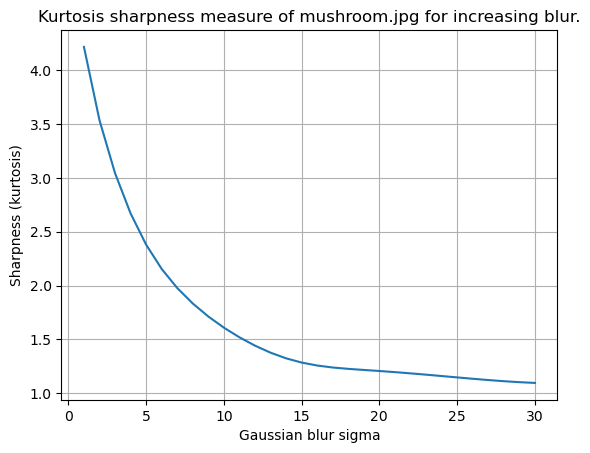

In [2]:
import scipy.stats as stats
import skimage.io as skio
import matplotlib.pyplot as plt
%matplotlib inline

def test_blur_measure(I, min_sigma, max_sigma):
    '''
    Finish me!
    
    :param I: 
    :param min_sigma: 
    :param max_sigma: 
    :return: 
    '''
    sigmas = list(range(min_sigma, max_sigma+1))
    sharpness_measures = []

    for sigma in sigmas:
        # Apply Gaussian blur to the image
        blurred = filt.gaussian(I, sigma=sigma, channel_axis = -1)
        
        # Compute gradient magnitude using color_sobel_edges
        gradient_magnitude, direction = color_sobel_edges(blurred)
        
        # Reshape the gradient magnitude to 1D and compute kurtosis
        k = stats.kurtosis(gradient_magnitude.reshape(-1))
        
        # Compute the sharpness measure as described
        sharpness_measure = np.log(k + 3)
        sharpness_measures.append(sharpness_measure)

    return (sigmas, sharpness_measures)

# Load the image
img = skio.imread('mushroom.jpg')

# Plot a line graph of gaussian blur sigma vs. blur measure (kurtosis)
sigmas, measures = test_blur_measure(img, 1, 30)
plt.plot(sigmas, measures)
plt.xlabel('Gaussian blur sigma')
plt.ylabel('Sharpness (kurtosis)')
plt.title('Kurtosis sharpness measure of mushroom.jpg for increasing blur.')
plt.grid(True)
plt.show()


# Step 3:  Create a local blur map

Write a function which:

* takes as input an image and a window size (in pixels).
* computes the local sharpness of the input image (i.e. log(kurtosis+3)) for each tiled, non-overlapping square window of the given window size
* stores each local sharpness in an array where each entry represents one window of the input image (the size of this array can be computed by integer division of the original image dimensions by the window size)
* returns the array of local sharpnesses.

Then:

- call the function you just wrote with `mushroom.jpg` as the input image and 100 as the window size.  
- Plot the returned array as an image using `plt.imshow()`.  Do not rescale this image with `vmin=` or `vmax=`, and use the default colormap (don't change it to `'gray'`).  
- Add a color scale bar using `plt.colorbar()`.  Sample output is provided in the assignment description document.



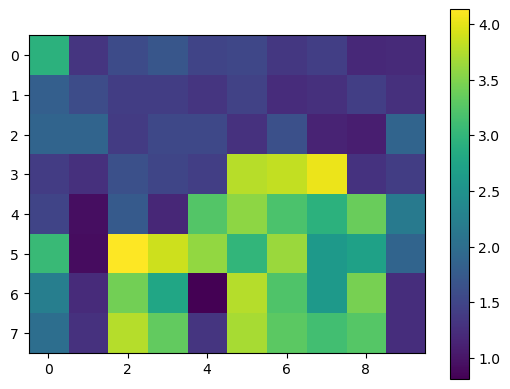

In [3]:
def sharpness_map(I, window_size):
    '''
    
    Finish me!
    
    :param I: 
    :param window_size: 
    :return: 
    '''
    # Determine the size of the output map
    rows, cols, _ = I.shape
    output_rows = rows // window_size
    output_cols = cols // window_size

    # Initialize an empty array to hold local sharpness values
    sharpness_array = np.zeros((output_rows, output_cols))

    # Loop through the image using the specified window size
    for r in range (output_rows):
        for c in range(output_cols):
            # Get the current window from the image
            window = I[r*window_size:(r+1)*window_size, c*window_size:(c+1)*window_size]

            # Get the gradient magnitude for the current window
            measure, direction = color_sobel_edges(window)

            # Calculate the sharpness for the current window
            k = stats.kurtosis(measure.reshape(-1))
            sharpness = np.log(k + 3)
            
            # Store the sharpness value in the output array
            sharpness_array[r, c] = sharpness

    return sharpness_array

# Load the image
img = skio.imread('mushroom.jpg')

# Get the local blur map with a window size of 100 pixels
blur_map = sharpness_map(img, 100)

# Plot the blur map
myfigure = plt.figure()
plt.imshow(blur_map)
plt.colorbar()

# Step 4: Try it on another image.

Use the functions you wrote to produce the same plots as in steps 2 and 3 but for the `waterfall.jpg` image instead.


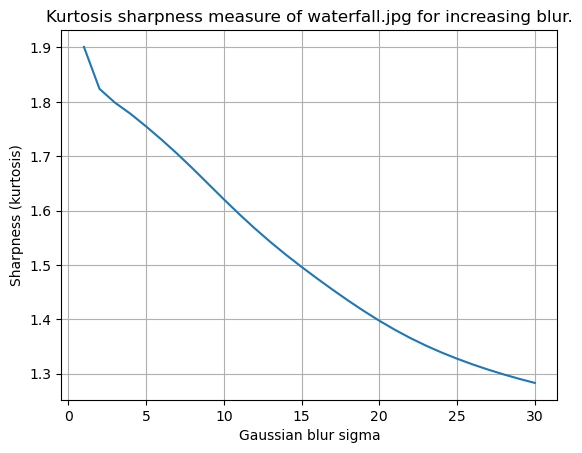

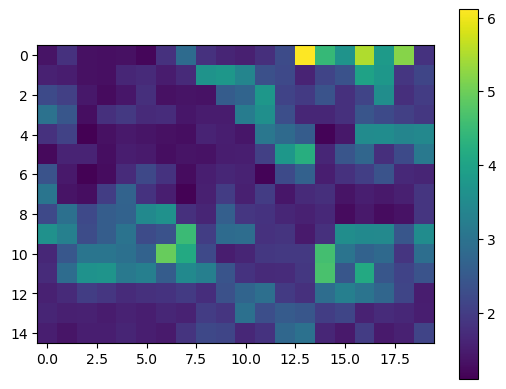

In [4]:
# Write your code here.
img = skio.imread('waterfall.jpg')

myfigure2 = plt.figure()

# Plot a line graph of gaussian blur sigma vs. blur measure (kurtosis)
sigmas, measures = test_blur_measure(img, 1, 30)
plt.plot(sigmas, measures)
plt.xlabel('Gaussian blur sigma')
plt.ylabel('Sharpness (kurtosis)')
plt.title('Kurtosis sharpness measure of waterfall.jpg for increasing blur.')
plt.grid(True)
plt.show()

# Get the local blur map with a window size of 100 pixels
blur_map = sharpness_map(img, 100)

# Plot the blur map
plt.imshow(blur_map)
plt.colorbar()

# Step 5: Thinking and Qualitative Analysis

### Answer the following questions, right here in this block.

1. Based on your observations of the previous results (you can try it on additional images if you wish), discuss the advantages and disadvantages of the kurtosis-based measure of image sharpness, citing specific evidence observed to justify your claims.

	_Your answer:_
    
    * _Advantage:_
    
    + This is a quick and simple measure. It involves a straightforward statistical computation based on the gradient magnitude, making it relatively easy to implement and understand.
    <br>
    
    + Since the gradient magnitude is large at the edges, the kurtosis-based measure is sensitive to the edges.
    <br>
    
    + By analyzing the graph of kurtosis sharpness for increasing Gaussian blur sigma, we can gain valuable insights into the impact of different levels of blur on image sharpness. This analysis allows us to assess the effects of varying levels of blur on the image and determine the optimal sigma value for noise reduction while maintaining appropriate image sharpness. As the observations of the previous results, for the `mushroom.jpg`, it is observed that sharpness undergoes a rapid exponential decline as sigma decreases. Conversely, in the case of `waterfall.jpg`, sharpness exhibits a more gradual, linear decline with increasing sigma values. This highlights that for `mushroom.jpg`, lower sigma values result in a dramatic reduction in sharpness, while for `waterfall.jpg`, the impact of sigma changes on sharpness is more consistent and gradual.
     <br> 
     
    + By analyzing the blur map for each image using Kurtosis, we can detect which areas with higher sharpness compared to others, indicating the presence of edges.
    <br>
    
    + Examining the two-color blur map allows us to identify which image has many regions of significant change and which image has more uniform regions. 
    
    * _Disadvantage:_
    
    + Kurtosis-based methos is computed based on gradient magnitude, which means it inherits potential limitations from the gradient magnitude calculation algorithm.
    <br>
    
    + Thus, similar to gradient magnitude, Kurtosis is sensitive to random noise, which can result in potential misinterpretations in the sharpness map, particularly in areas of the image with high noise levels. As demonstrated in the code below, when applied to the `waterfall.jpg` image with added random noise, the blur map of Kurtosis sharpness measure identifies more regions with higher sharpness than it showed in the blur map of original image.
    <br>
    
    + It's challenging to see changes in sharpness in blurry images, especially when the gradient magnitude is low, as the variations tend to be subtle. This is illustrated in the graph of `mushroom.jpg`, where, at high sigma values around 30, the sharpness detected by Kurtosis appears nearly consistent.
    <br>
    
2. Think of what the shape of a histogram of gradient magnitudes would look like for a sharp image.  Why does this set of gradient magnitudes have high kurtosis?  (It might help to look up kurtosis and see what it measures about a histogram!)

	_Your answer:_  
    
    In a sharp image, the histogram of gradient magnitude exhibits big differences between its peaks, indicating areas with substantial gradient magnitudes, typically associated with edges. These peaks are distributed across a broad range of gradient magnitudes. 
    
    The high kurtosis for this set of gradient magnitudes is a result of the numerous large gaps between gradient magnitudes, because higher kurtosis corresponds to greater extremity of deviations (or outliers) (_Kurtosis, Wikipedia_). The formula for kurtosis is calculated as follows (_source: Javier Parra, 'Statistical and Graphical Analysis - Univariate Analysis,' https://www.javierparra.net/en/ecoknowmic-en/statistical-and-graphical-analysis-univariate-analysis/_)."  
    
    $Kurtosis = \frac{\frac{1}{N} \sum_{i=1}^{N} (x_i - \bar{x})^4}{\left( \frac{1}{N} \sum_{i=1}^{N} (x_i - \bar{x})^2 \right)^2}$
 
    In simpler terms, this formula measures kurtosis by examining the fourth moment of the data distribution in relation to its variance. Thus, the data has many large differences or extreme values, it will have high kurtosis.
    <br>
    
3. Now think what would happen as that same image gets blurrier.  Explain how the shape of the histogram would change, and the corresponding effect on the kurtosis.

	_Your answer:_ 
    
    If the same image gets blurrier, the histogram of gradient would become flatter. This indicates a reduction in high gradient values, which are associated with less sharp edges. The value of the peaks will be smaller, the different between the peaks will be closer and peaks will be distributed in a tighter range of gradient magnitude in comparison with sharp image. 
    
    As a result, the kurtosis would decrease because there would be fewer outlier gradient values that signify sharpness.
    
    I've provided a code snippet below to illustrate the difference between histogram of gradient magnitude for a sharp and a blurrier image.

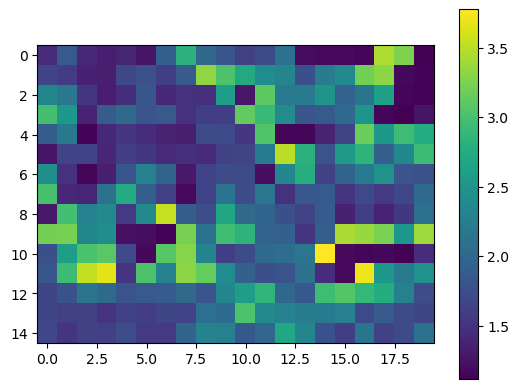

In [6]:
#Illustrate the blur map for noisy waterfall.jpg image

import skimage.util as skutil
import skimage.io as skio

img = skio.imread('waterfall.jpg')

# Add noise to the image
noiseless_float = skutil.img_as_float(img)
    
noisy = skutil.random_noise(noiseless_float, mode='gaussian', var=0.01)

# Get the local blur map with a window size of 100 pixels
blur_map_noisy = sharpness_map(noisy, 100)

# Plot the blur map for noisy image
plt.figure()
plt.imshow(blur_map_noisy)
plt.colorbar()

<Figure size 1200x600 with 0 Axes>

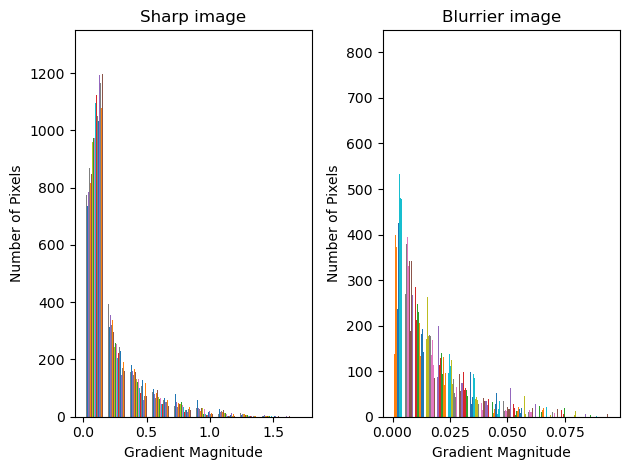

In [27]:
img = skio.imread('waterfall.jpg')

# Compute gradient magnitude using color_sobel_edges
gradient_magnitude, direction = color_sobel_edges(img)

plt.figure(figsize = (12,6))
plt.subplots(1,2)

# Display the histogram
plt.subplot(1,2,1)
plt.hist(gradient_magnitude)
plt.title('Sharp image')
plt.xlabel('Gradient Magnitude')
plt.ylabel('Number of Pixels')

# Apply Gaussian blur to the image
blurred = filt.gaussian(img, sigma=10, channel_axis = -1)
        
# Compute gradient magnitude using color_sobel_edges
gradient_magnitude_blur, direction_blur = color_sobel_edges(blurred)

# Display the histogram of blurrier image
plt.subplot(1,2,2)
plt.hist(gradient_magnitude_blur, bins = 20)
plt.title('Blurrier image')
plt.xlabel('Gradient Magnitude')
plt.ylabel('Number of Pixels')

plt.tight_layout()